# 05a: Data Preparation for CNN-LSTM

This notebook provides a comprehensive, stepwise workflow for preparing ICU time series and static data for deep learning models.

**Goals:**
- Prepare dynamic (time series), static, and outcome data for CNN-LSTM modeling
- Select clinically relevant features and apply appropriate transformations
- Address missingness, scaling, and class imbalance
- Construct patient-level sequences and align static features
- Save processed datasets for downstream modeling and analysis


## Workflow Overview

This notebook prepares ICU time series and static data for CNN-LSTM modeling. The workflow includes:

1. **Data Loading and Audit:** Load cleaned data, preview, and check types.
2. **Feature Selection:** Select EDA-driven dynamic and static features.
3. **Log Transformation:** Apply log1p to skewed static features.
4. **Sequence Construction:** Group by patient, extract sequences and static features.
5. **Padding and Scaling:** Pad sequences and scale features.
6. **Train/Val/Test Split:** Patient-index-based splitting for alignment.
7. **Class Imbalance Handling:** Apply SMOTE to training set.
8. **Save Processed Data:** Store arrays for modeling.






## 1. Imports and Configuration

Import all necessary libraries for data preparation, including pandas, numpy, scikit-learn, imbalanced-learn, and TensorFlow. Set random seeds for reproducibility and configure display/plotting options for consistency.


In [1]:
# Imports and Configuration
import pandas as pd
import numpy as np
import random
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

2025-08-06 12:18:11.255184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data Loading and Initial Audit

Load the cleaned ICU dataset and missingness mask. Preview the first few rows and check data types to confirm correct loading. Summarize the shape and schema of the dataset for transparency.

In [2]:
# Load cleaned data
data = pd.read_csv('../data/processed/timeseries_cleaned_all_features.csv')
mask = pd.read_csv('../data/processed/timeseries_missingness_mask.csv')
print('Data shape:', data.shape)

# Preview
display(data.head())
print(data.dtypes)

Data shape: (295354, 48)


,RecordID,Minutes,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,DiasABP,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,MAP,MechVent,Mg,NIDiasABP,NIMAP,NISysABP,Na,PaCO2,PaO2,Platelets,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,pH,Age,Gender,Height,ICUType,In-hospital_death,Length_of_stay,SAPS-I,SOFA,Survival,Weight
0,132539,7,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.8,0.0,0.0,15.0,205.0,26.0,33.7,73.0,4.4,0.0,0.0,0.0,1.5,65.0,92.33,147.0,137.0,0.0,0.0,221.0,19.0,0.0,0.0,35.1,0.0,0.0,900.0,11.2,0.0,54.0,0.0,170.2,4.0,0.0,5.0,6.0,1.0,70.0,78.6
1,132539,37,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.8,0.0,0.0,15.0,205.0,26.0,33.7,77.0,4.4,0.0,0.0,0.0,1.5,58.0,91.00,157.0,137.0,0.0,0.0,221.0,19.0,0.0,0.0,35.6,0.0,0.0,60.0,11.2,0.0,54.0,0.0,170.2,4.0,0.0,5.0,6.0,1.0,70.0,78.6
2,132539,97,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.8,0.0,0.0,15.0,205.0,26.0,33.7,60.0,4.4,0.0,0.0,0.0,1.5,62.0,87.00,137.0,137.0,0.0,0.0,221.0,18.0,0.0,0.0,35.6,0.0,0.0,30.0,11.2,0.0,54.0,0.0,170.2,4.0,0.0,5.0,6.0,1.0,70.0,78.6
3,132539,157,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.8,0.0,0.0,15.0,205.0,26.0,33.7,62.0,4.4,0.0,0.0,0.0,1.5,52.0,75.67,123.0,137.0,0.0,0.0,221.0,19.0,0.0,0.0,35.6,0.0,0.0,170.0,11.2,0.0,54.0,0.0,170.2,4.0,0.0,5.0,6.0,1.0,70.0,78.6
4,132539,188,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.8,0.0,0.0,15.0,205.0,26.0,33.7,62.0,4.4,0.0,0.0,0.0,1.5,52.0,75.67,123.0,137.0,0.0,0.0,221.0,19.0,0.0,0.0,35.6,0.0,0.0,170.0,11.2,0.0,54.0,0.0,170.2,4.0,0.0,5.0,6.0,1.0,70.0,78.6


RecordID               int64
Minutes                int64
ALP                  float64
ALT                  float64
AST                  float64
Albumin              float64
BUN                  float64
Bilirubin            float64
Cholesterol          float64
Creatinine           float64
DiasABP              float64
FiO2                 float64
GCS                  float64
Glucose              float64
HCO3                 float64
HCT                  float64
HR                   float64
K                    float64
Lactate              float64
MAP                  float64
MechVent             float64
Mg                   float64
NIDiasABP            float64
NIMAP                float64
NISysABP             float64
Na                   float64
PaCO2                float64
PaO2                 float64
Platelets            float64
RespRate             float64
SaO2                 float64
SysABP               float64
Temp                 float64
TroponinI            float64
TroponinT     

## 2. Feature Selection

Select features based on EDA findings and clinical relevance.

- **Dynamic (time series) features:**
    - Cardiovascular: HR, SysABP, DiasABP, MAP, NISysABP, NIDiasABP, NIMAP, MechVent
    - Respiratory: RespRate, SaO2, FiO2, PaO2, PaCO2
    - Renal: Creatinine, BUN, Urine
    - Metabolic/Electrolytes: Na, K, Glucose, Lactate, HCO3, pH
    - Neurological: GCS
    - Other: Temp
- **Static features:**
    - Age, Gender, Height, Weight, ICUType, SAPS-I, SOFA, Length_of_stay, Survival
- **Target:**
    - In-hospital_death (binary)

In [3]:
# Dynamic (time series) features
time_series_features = [
    'HR', 'SysABP', 'DiasABP', 'MAP', 'NISysABP', 'NIDiasABP', 'NIMAP', 'MechVent',
    'RespRate', 'SaO2', 'FiO2', 'PaO2', 'PaCO2',
    'Creatinine', 'BUN', 'Urine',
    'Na', 'K', 'Glucose', 'Lactate', 'HCO3', 'pH',
    'GCS', 'Temp',
    # Clinically meaningful combinations of vitals
    'Shock Index',          # HR / SysABP
    'PaO2/FiO2 ratio',      # PaO₂ / FiO₂
    'Pulse Pressure',       # SysABP − DiasABP
    'MAP to HR ratio'       # MAP / HR
]

# Static features
# static_features = [
#     'Age', 'Gender', 'Height', 'Weight', 'ICUType', 'SAPS-I', 'SOFA',
#     'Length_of_stay', 'Survival'
# ]

# Static features (removed Length_of_Stay and Survival to prevent data leakage) - Suvo
static_features = ['Age', 'Gender', 'Height', 'Weight', 'ICUType', 'SAPS-I', 'SOFA']

target_col = 'In-hospital_death'

# Derived features
data['Shock Index'] = np.where(
    data['SysABP'] > 0,
    data['HR'] / data['SysABP'],
    np.nan
)

data['PaO2/FiO2 ratio'] = np.where(
    data['FiO2'] > 0,
    data['PaO2'] / data['FiO2'],
    np.nan
)

data['Pulse Pressure'] = np.where(
    (data['SysABP'].notna()) & (data['DiasABP'].notna()),
    data['SysABP'] - data['DiasABP'],
    np.nan
)

data['MAP to HR ratio'] = np.where(
    data['HR'] > 0,
    data['MAP'] / data['HR'],
    np.nan
)

print("Dynamic Features:", time_series_features)
print("Static Features:", static_features)
print("Target:", target_col)

Dynamic Features: ['HR', 'SysABP', 'DiasABP', 'MAP', 'NISysABP', 'NIDiasABP', 'NIMAP', 'MechVent', 'RespRate', 'SaO2', 'FiO2', 'PaO2', 'PaCO2', 'Creatinine', 'BUN', 'Urine', 'Na', 'K', 'Glucose', 'Lactate', 'HCO3', 'pH', 'GCS', 'Temp', 'Shock Index', 'PaO2/FiO2 ratio', 'Pulse Pressure', 'MAP to HR ratio']
Static Features: ['Age', 'Gender', 'Height', 'Weight', 'ICUType', 'SAPS-I', 'SOFA']
Target: In-hospital_death


## 3. Log Transformation of Skewed Features

Apply log1p transformation to highly skewed static features to improve model performance and reduce the impact of outliers. We dynamically identify features with absolute skewness > 1.0 and apply appropriate transformations.

**Process:**
- Calculate skewness for all numeric static features
- Identify features with high skewness (|skewness| > 1.0)
- Apply log1p transformation to reduce skewness
- Validate transformation results

In [4]:
# Dynamically identify highly skewed static features
skewed_features = []
static_features_for_skew_check = [col for col in static_features if col not in ['Gender', 'ICUType']]

# Calculate skewness, drop NA values for accurate calculation
skewness = data[static_features_for_skew_check].skew().sort_values(ascending=False)

# Define a threshold for high skewness (e.g., absolute skewness > 1)
skewness_threshold = 1.0
highly_skewed_features = skewness[abs(skewness) > skewness_threshold].index.tolist()

print(f"Highly skewed features (absolute skewness > {skewness_threshold}): {highly_skewed_features}")

# Apply log1p transformation to the identified highly skewed features
for col in highly_skewed_features:
    if col in data.columns:
        # Check if the column contains non-positive values before applying log1p
        if (data[col] < 0).any():
            print(f"Warning: Column '{col}' contains negative values. log1p may not be appropriate.")
            pass 
        else:
            data[col] = np.log1p(data[col])
            print(f"Applied log1p to '{col}'")
    else:
        print(f"Warning: Column '{col}' not found in data.")

Highly skewed features (absolute skewness > 1.0): ['Height', 'Weight']
Applied log1p to 'Height'
Applied log1p to 'Weight'


## 4. Time Series Data Visualization

Visualize time series patterns for selected patients and features to understand data characteristics and temporal trends. This helps validate data quality and identify potential patterns.

**Visualization includes:**
- Random sample of patient records  
- Key physiological parameters over time
- Temporal patterns and missing data assessment

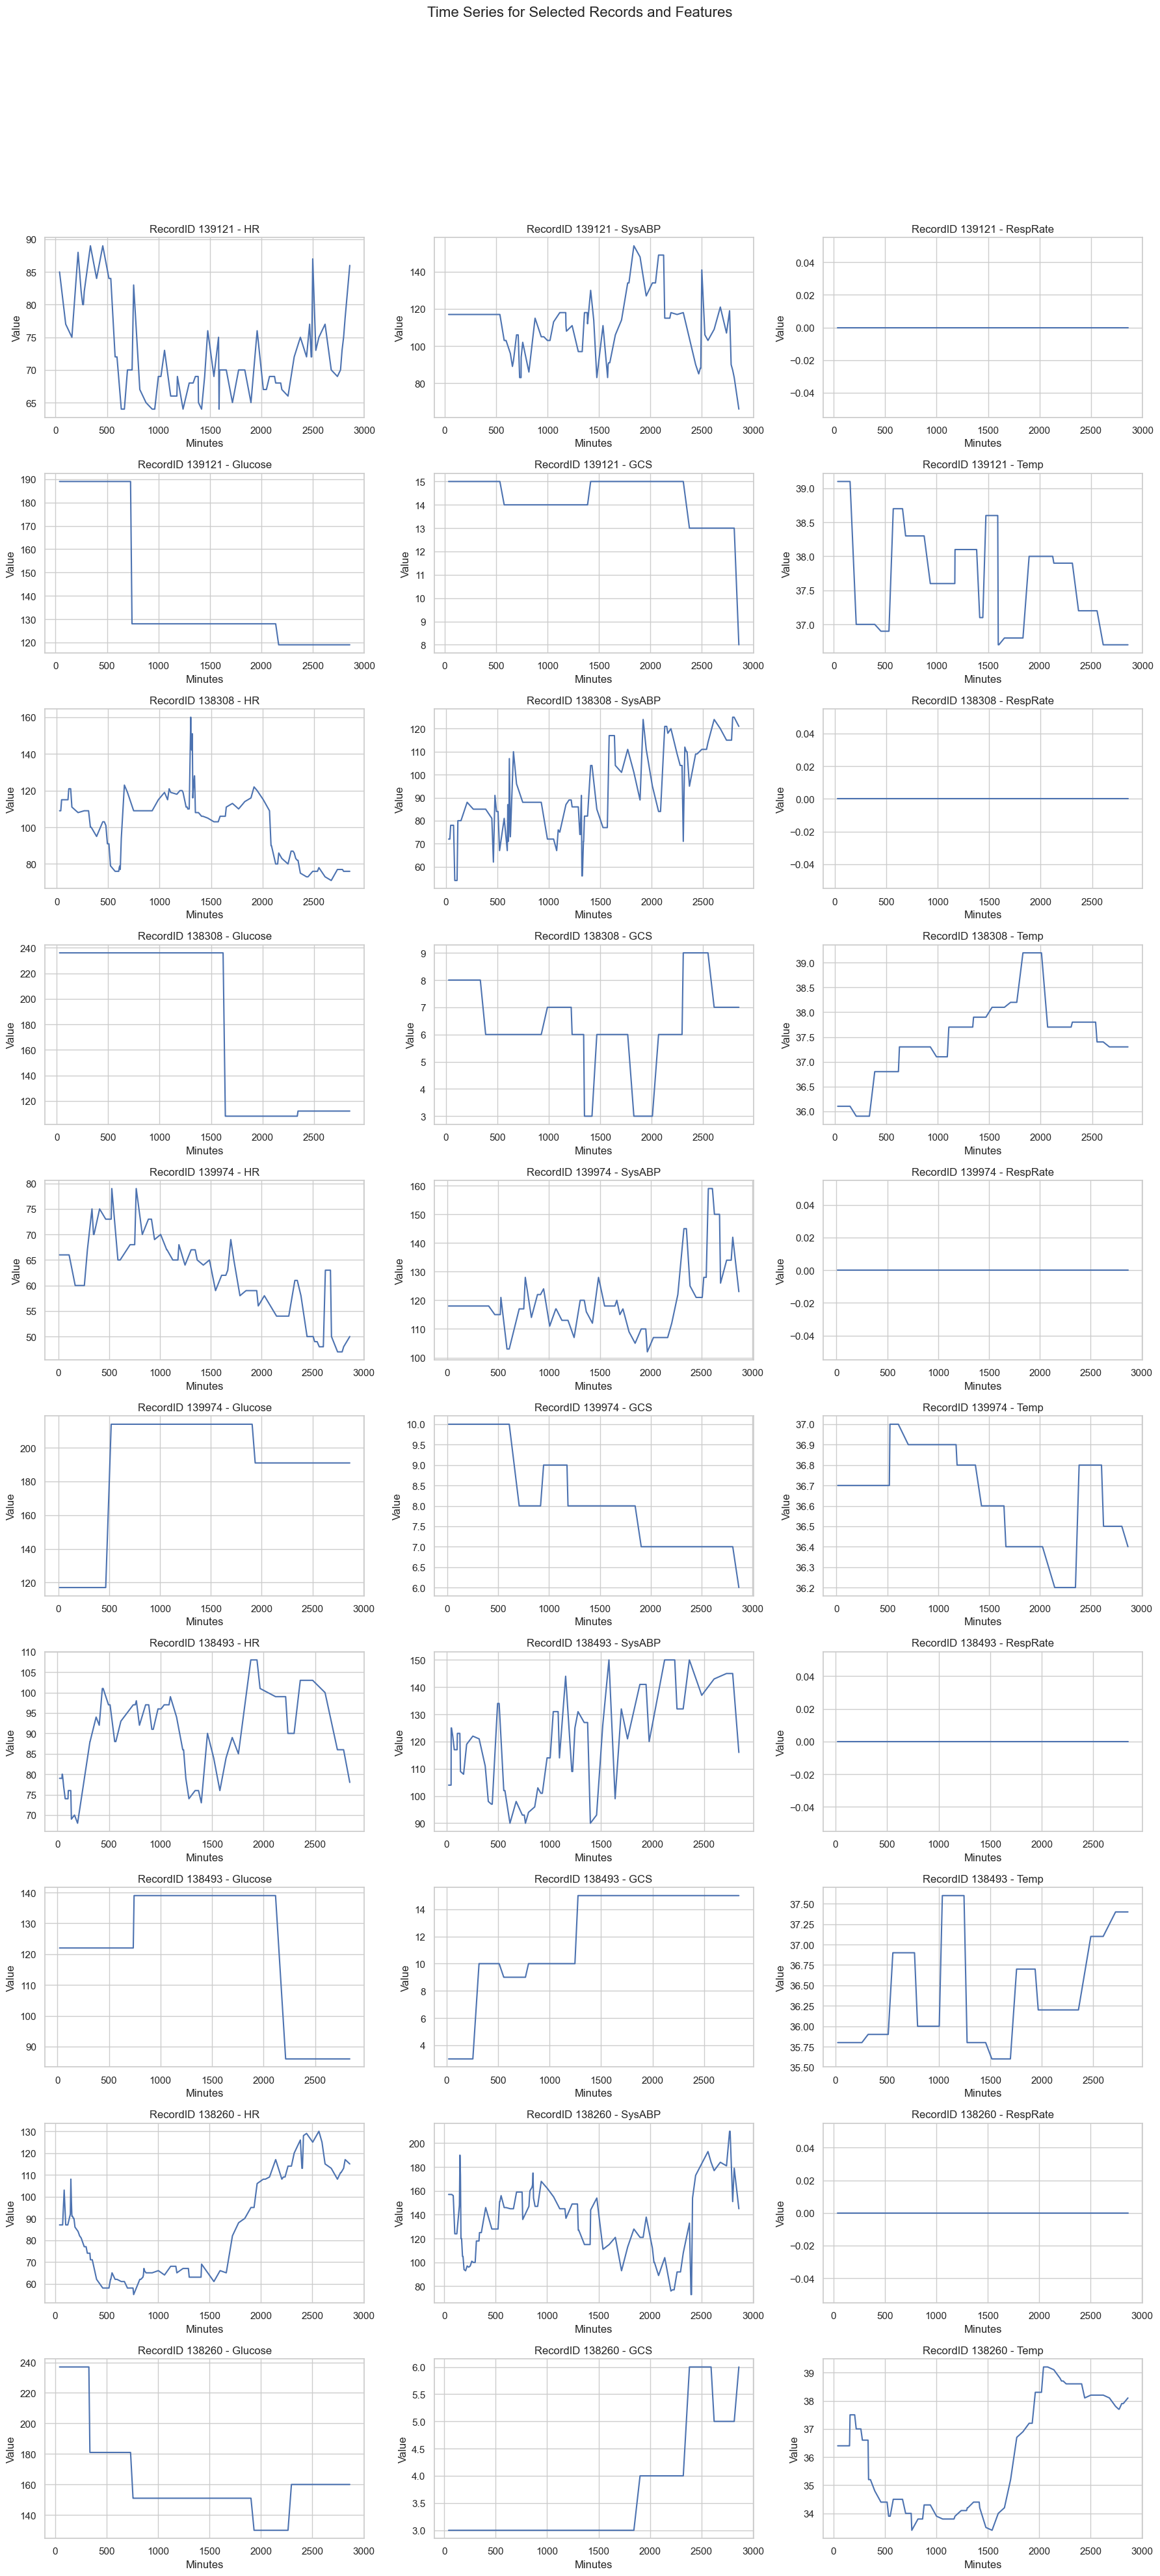

In [5]:
# Visualize time series for selected patient records
# Get a list of unique RecordIDs
record_ids = data['RecordID'].unique()

# Select a few random RecordIDs to visualize
num_records_to_visualize = 5 # You can change this number
selected_record_ids = random.sample(list(record_ids), num_records_to_visualize)

# Select a subset of dynamic features to visualize
features_to_plot = ['HR', 'SysABP', 'RespRate', 'Glucose', 'GCS', 'Temp'] 

grouped = data.groupby('RecordID')

n_plots = num_records_to_visualize * len(features_to_plot)
n_cols = min(len(features_to_plot), 3) 
n_rows = math.ceil(n_plots / n_cols)

plt.figure(figsize=(n_cols * 6, n_rows * 4)) 
plt.suptitle('Time Series for Selected Records and Features', y=1.02, fontsize=16)

plot_index = 1
for record_id in selected_record_ids:
    group = grouped.get_group(record_id)

    for col in features_to_plot:
        if col in group.columns: 
            plt.subplot(n_rows, n_cols, plot_index)
            plt.plot(group['Minutes'], group[col]) 
            plt.title(f'RecordID {record_id} - {col}')
            plt.xlabel('Minutes')
            plt.ylabel('Value')
            plot_index += 1
        else:
            print(f"Warning: Feature '{col}' not found for RecordID {record_id}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

## 5. Hourly Sequence Construction

Create hourly time series sequences for CNN-LSTM modeling. This step transforms irregular time series data into structured hourly windows suitable for deep learning models.

**Process:**
- Define 1-hour window boundaries (60-minute intervals)
- Group data by patient (RecordID)
- Extract first measurement within each hourly window
- Handle missing data with NaN placeholders
- Create patient-level sequence arrays

**Output:** 3D array with shape (n_patients, n_time_steps, n_features)

### 5.1 Static Data Preparation

Extract and prepare static features for each patient. Static features remain constant throughout each patient's ICU stay and will be used alongside the time series data.

**Process:**
- Extract one row per patient for static features
- Create target variable array
- Ensure alignment with sequence data

In [6]:
# Extract static features for each patient (one row per patient)
patient_static_data = data.groupby('RecordID')[static_features].first().reset_index()

# Extract target variable
patient_outcomes = data.groupby('RecordID')[target_col].first().reset_index()

# Convert to arrays
X_static = patient_static_data[static_features].values
y = patient_outcomes[target_col].values

print("Shape of static features:", X_static.shape)
print("Shape of target variable:", y.shape)
print("Class distribution:", np.unique(y, return_counts=True))

Shape of static features: (3997, 7)
Shape of target variable: (3997,)
Class distribution: (array([0., 1.]), array([3443,  554]))


### 5.2 Dynamic Sequence Construction

Transform irregular time series measurements into structured hourly sequences. Each patient will have a sequence of hourly feature vectors suitable for sequential modeling.

In [7]:
hourly_sequences = []

# Define hourly window size
hour_window_size = 60  # 1 hour in minutes
max_time = 2880  # 48 hours in minutes
hourly_window_boundaries = np.arange(0, max_time + hour_window_size, hour_window_size)


# Iterate through each patient's data, grouped by RecordID.
for record_id, group in data.groupby('RecordID'):
    patient_sequence = []
    # For each patient, iterate through the defined hourly window boundaries.
    # We iterate up to the second to last boundary to define the end of the window
    for i in range(len(hourly_window_boundaries) - 1):
        start_time = hourly_window_boundaries[i]
        end_time = hourly_window_boundaries[i+1]

        # For each window, filter the patient's time-series data
        window_data = group[(group['Minutes'] >= start_time) & (group['Minutes'] < end_time)]

        # If there are multiple data points within an hour, take the first one.
        # If there are no data points, use a placeholder (e.g., NaN or 0, depending on how missingness is handled later).
        if not window_data.empty:
            # Select the time series features for the first data point in the window
            hourly_features = window_data[time_series_features].iloc[0].values
        else:
            # If no data points in the window, create a placeholder array of NaNs
            hourly_features = np.full(len(time_series_features), np.nan) 

        patient_sequence.append(hourly_features)

    # Collect the hourly feature arrays for all windows for the current patient
    # Append the list of hourly window features for the current patient
    hourly_sequences.append(patient_sequence)

# Convert the list of hourly sequences into a NumPy array.
X_hourly_seq = np.array(hourly_sequences, dtype=np.float32)

print("Shape of hourly time series sequences:", X_hourly_seq.shape)

Shape of hourly time series sequences: (3997, 48, 28)


## 6. Sequence Padding and Scaling

Prepare sequences for CNN-LSTM input by padding to uniform length and scaling features.

In [8]:
# Pad sequences
# The max_seq_len should be 48 for hourly data over 48 hours
max_seq_len = 48 # 48 hours * 1 hour/step = 48 steps

# Ensure X_hourly_seq is available from the previous step
if 'X_hourly_seq' not in locals():
    print("Error: X_hourly_seq not found. Please run the previous cell to generate hourly sequences.")
else:
    X_seq_padded = pad_sequences(X_hourly_seq, maxlen=max_seq_len, dtype='float32', padding='post', value=0.0)

    # Scale features
    scaler = StandardScaler()
    n_features = X_hourly_seq.shape[2] # Get the number of features from the hourly data
    X_seq_reshaped = X_seq_padded.reshape(-1, n_features)
    X_seq_scaled = scaler.fit_transform(X_seq_reshaped).reshape(-1, max_seq_len, n_features)

    print(f"Padded and scaled sequences for hourly data.")
    print("Shape of padded sequences:", X_seq_padded.shape)
    print("Shape of scaled sequences:", X_seq_scaled.shape)

Padded and scaled sequences for hourly data.
Shape of padded sequences: (3997, 48, 28)
Shape of scaled sequences: (3997, 48, 28)


## 7. Data Splitting and  Processing

Perform comprehensive data preparation including stratified splitting, data cleaning, feature scaling, missing value imputation, and class balancing for CNN-LSTM modeling.

### Process Overview:

**1. Patient-Level Stratified Splitting:**
- Split data at patient level to prevent data leakage
- Train: 64%, Validation: 16%, Test: 20%
- Maintain class distribution across all splits

**2. Data Cleaning:**
- Replace NaN values with 0.0
- Cap infinite values (positive: 1e6, negative: -1e6)
- Ensure numerical stability for training

**3. Feature Scaling:**
- Apply StandardScaler to static features
- Fit on training set, transform validation and test sets
- Normalize feature distributions

**4. Missing Value Imputation:**
- Flatten dynamic sequences for imputation
- Use mean strategy for missing time series values
- Apply fitted imputer to validation and test sets
- Reshape back to original sequence format

**5. Class Imbalance Handling (SMOTE):**
- Apply SMOTE oversampling to training set only
- Generate synthetic samples for minority class
- Handle corresponding static features for synthetic samples

**6. Final Data Assembly:**
- Create final arrays ready for CNN-LSTM training
- Validate data integrity and shapes
- Perform quality checks for NaN/Inf values

In [9]:
# Get patient indices
# n_patients = X_seq_scaled.shape[0]
# indices = np.arange(n_patients)

# # Stratified split
# train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=42)
# train_idx, val_idx  = train_test_split(train_idx, test_size=0.2, stratify=y[train_idx], random_state=42)

# # Split datasets
# X_train, X_val, X_test = X_seq_scaled[train_idx], X_seq_scaled[val_idx], X_seq_scaled[test_idx]
# static_train, static_val, static_test = X_static[train_idx], X_static[val_idx], X_static[test_idx]
# y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

# --------- Updated code (Suvo) ----------------
# Previous approach used train_test_split on individual sequences, which risked data leakage:
# sequences from the same patient could appear in both training and test sets.
# 
# This updated version ensures patient-level splitting:
# - Groups by unique RecordIDs before splitting.
# - Guarantees that all time series data from a single patient stays entirely within one split
#   (train, validation, or test).
# - Prevents overfitting from memorizing patient-specific patterns.

import pandas as pd
from sklearn.model_selection import train_test_split

df_ids = pd.DataFrame({'RecordID': record_ids, 'Label': y})
unique_ids = df_ids.drop_duplicates('RecordID')

# Split data 
train_ids, test_ids = train_test_split(
    unique_ids['RecordID'], 
    test_size=0.2, 
    stratify=unique_ids['Label'], 
    random_state=42
)

train_ids, val_ids = train_test_split(
    train_ids, 
    test_size=0.2, 
    stratify=unique_ids.set_index('RecordID').loc[train_ids]['Label'], 
    random_state=42
)

# Create masks
train_idx = df_ids['RecordID'].isin(train_ids).values
val_idx   = df_ids['RecordID'].isin(val_ids).values
test_idx  = df_ids['RecordID'].isin(test_ids).values

# Apply splits
X_train = X_seq_scaled[train_idx]
X_val   = X_seq_scaled[val_idx]
X_test  = X_seq_scaled[test_idx]

static_train = X_static[train_idx]
static_val   = X_static[val_idx]
static_test  = X_static[test_idx]

y_train = y[train_idx]
y_val   = y[val_idx]
y_test  = y[test_idx]

# ---------------------------------------


# Clean NaNs/Infs before processing
def clean_array(arr):
    return np.nan_to_num(arr, nan=0.0, posinf=1e6, neginf=-1e6)

X_train = clean_array(X_train)
X_val   = clean_array(X_val)
X_test  = clean_array(X_test)

static_train = clean_array(static_train)
static_val   = clean_array(static_val)
static_test  = clean_array(static_test)

# Scale static features
static_scaler = StandardScaler()
static_train_scaled = static_scaler.fit_transform(static_train)
static_val_scaled   = static_scaler.transform(static_val)
static_test_scaled  = static_scaler.transform(static_test)

# Impute dynamic features (fit on train, apply to val/test)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
imputer = SimpleImputer(strategy='mean')
X_train_imputed_flat = imputer.fit_transform(X_train_flat)

X_val_flat  = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_imputed_flat  = imputer.transform(X_val_flat)
X_test_imputed_flat = imputer.transform(X_test_flat)

# Reshape back to original sequence format
X_train_imputed = X_train_imputed_flat.reshape(-1, X_train.shape[1], X_train.shape[2])
X_val_imputed   = X_val_imputed_flat.reshape(-1, X_val.shape[1], X_val.shape[2])
X_test_imputed  = X_test_imputed_flat.reshape(-1, X_test.shape[1], X_test.shape[2])

# Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_res_flat, y_train_res = smote.fit_resample(X_train_imputed_flat, y_train)
X_train_res = X_train_res_flat.reshape(-1, X_train_imputed.shape[1], X_train_imputed.shape[2])

# Handle static features for synthetic samples
n_orig = static_train_scaled.shape[0]
n_total = X_train_res.shape[0]
n_synth = n_total - n_orig

static_train_res = static_train_scaled.copy()
if n_synth > 0:
    minority_class = 1 if np.sum(y_train == 1) < np.sum(y_train == 0) else 0
    minority_indices = np.where(y_train == minority_class)[0]
    synth_static = static_train_scaled[np.random.choice(minority_indices, size=n_synth, replace=True)]
    static_train_res = np.concatenate([static_train_scaled, synth_static], axis=0)

X_train_final = X_train_res
y_train_final = y_train_res
static_train_final = static_train_res

X_val_final = X_val_imputed
static_val_final = static_val_scaled
y_val_final = y_val

X_test_final = X_test_imputed
static_test_final = static_test_scaled
y_test_final = y_test

# Final shapes and checks
print("Shapes:")
print("Train:", X_train_final.shape, static_train_final.shape, y_train_final.shape)
print("Val:",   X_val_final.shape, static_val_final.shape, y_val_final.shape)
print("Test:",  X_test_final.shape, static_test_final.shape, y_test_final.shape)

for arr, name in [
    (X_train_final, "X_train_final"), (X_val_final, "X_val_final"), (X_test_final, "X_test_final"),
    (static_train_final, "static_train_final"), (static_val_final, "static_val_final"), (static_test_final, "static_test_final")
]:
    print(f"{name} - NaNs: {np.isnan(arr).any()}, Infs: {np.isinf(arr).any()}")

Shapes:
Train: (4406, 48, 28) (4406, 7) (4406,)
Val: (640, 48, 28) (640, 7) (640,)
Test: (800, 48, 28) (800, 7) (800,)
X_train_final - NaNs: False, Infs: False
X_val_final - NaNs: False, Infs: False
X_test_final - NaNs: False, Infs: False
static_train_final - NaNs: False, Infs: False
static_val_final - NaNs: False, Infs: False
static_test_final - NaNs: False, Infs: False


## 8. Save Processed Data

Save the fully processed datasets for CNN-LSTM modeling. All data is ready for training with proper scaling, missing value handling, and class balancing applied.

In [10]:
# Save processed 1-hour sequence data
# np.savez('../data/processed/cnn_lstm_hourly_data.npz',
#          X_train=X_train_final, y_train=y_train_final,
#          X_val=X_val_final,   y_val=y_val_final,
#          X_test=X_test_final, y_test=y_test_final,
#          static_train=static_train_final,
#          static_val=static_val_final,
#          static_test=static_test_final)

# Added record_ids for debugging in 05b - Suvo
np.savez_compressed('../data/processed/cnn_lstm_hourly_data.npz',
    X_train=X_train_final,
    X_val=X_val_final,
    X_test=X_test_final,
    static_train=static_train_final,
    static_val=static_val_final,
    static_test=static_test_final,
    y_train=y_train_final,
    y_val=y_val_final,
    y_test=y_test_final,
    record_ids=record_ids 
)


print("Prepared hourly sequence data saved to ../data/processed/cnn_lstm_hourly_data.npz")

Prepared hourly sequence data saved to ../data/processed/cnn_lstm_hourly_data.npz
